In [1]:
import numpy as np
import pandas as pd
import AgentClass
import const
import random
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities
import copy

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
from random import shuffle

from scipy.spatial import distance

In [2]:
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)

In [3]:
def get_tau_distr():
    lower = 0
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [4]:
def create_environment():
    

    # bits shuffling for equal bits
    eq_bits = [[0 for i in range(num_agents//2)] + [1 for i in range(num_agents//2)] for i in range(number_of_bits)]
    for i in eq_bits:
        shuffle(i)
        
    list_agents = []
    tau_distr = get_tau_distr()
    for i in range(num_agents):

        in_state = [bit.pop() for bit in eq_bits]

        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.newman_watts_strogatz_graph(num_agents, 5, 0.5, seed= 0)
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents

In [5]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [6]:
def run_simulation(alpha, coherence, bit_mat, list_agents, end_time):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, coherence, bit_mat)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Number': int(agt.name.split('t')[1]),
                   'Time':t,
                   # at any time step we will need normalized how many neighbors disagree on bits
                   'bits_disagreement':np.array(agt.state_disagreements),
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'alpha':alpha,
                   'Next': utilities.bool2int(agt.next_state),
                   'Next_Knowledge_State':agt.next_state}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1

    return pd.DataFrame(d)

### The heatmap in the section below shows the coherence matrix with attractors and their depth and radius

In [7]:
random.seed(0)
number_attractors = 4 # assign number of attractors for the coherence matrix with attractor space

attractors = {}
while len(attractors) < number_attractors:
    attractor_state = random.randint(0,2**number_of_bits)
    attractor_depth = random.random() # depth for each attractors is picked randomly
    attractor_radius = random.randint(1, 3) # range of radius is randomly picked for each attractor
    
    attractors[attractor_state] = {'depth': attractor_depth, 'radius': attractor_radius}
    
attractors

{788: {'depth': 0.7579544029403025, 'radius': 2},
 82: {'depth': 0.25891675029296335, 'radius': 3},
 995: {'depth': 0.4049341374504143, 'radius': 2},
 976: {'depth': 0.3580493746949883, 'radius': 1}}

In [8]:
# attractors[788]['radius'] = 30

In [9]:
def hamming(a,b):
    return(bin(a^b).count("1"))

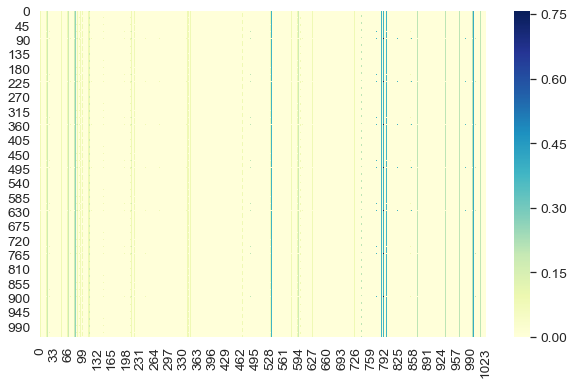

In [12]:
attrctr_space_vec = np.zeros(2**number_of_bits)

for k, v in attractors.items():
    attrctr_space_vec[k] = v['depth']
    r = v['radius']
    n = 2**number_of_bits
    for j in range(2**number_of_bits):
            diff = hamming(j, k)
#             diff = abs(j-k) ### Uncomment if needed to look into euclidean space
            if diff <= r:
                attrctr_state_distance = (1-diff/v['radius'])*v['depth']
                attrctr_space_vec[j] = max(attrctr_space_vec[j], attrctr_state_distance)
            
attrctr_space_mat = np.tile(attrctr_space_vec, (2**number_of_bits, 1))
        
sns.heatmap(attrctr_space_mat, cmap="YlGnBu");


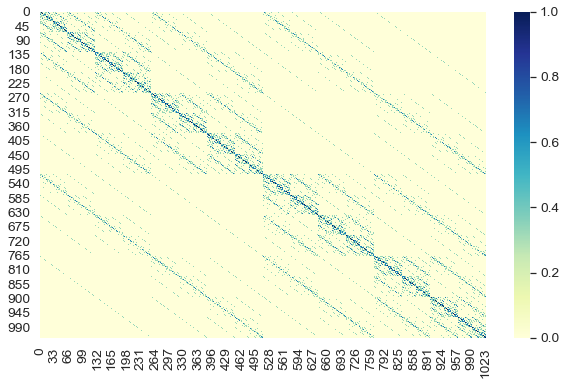

In [13]:
# create transition matrix
inertia_matrix = np.zeros((2**number_of_bits, 2**number_of_bits))

max_bits = 3 # maximum bits to for the transitions
    
for row_st, row in enumerate(inertia_matrix):
    for col_st, col in enumerate(row):
        bits_difference = hamming(row_st, col_st)
#         bits_difference = np.abs(row_st- col_st)
        inertia_matrix[row_st, col_st] = max(0, 1- bits_difference *(1/max_bits))

sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)
sns.heatmap(inertia_matrix, cmap="YlGnBu");

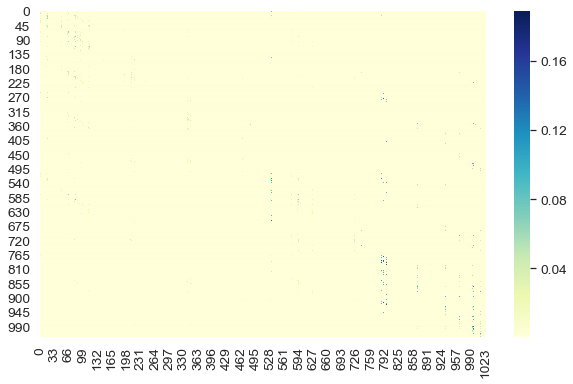

In [14]:
coherence_matrix = attrctr_space_mat*inertia_matrix

# add noise to coherence matrix:
for i, row in enumerate(coherence_matrix):
    for j, col in enumerate(row):
        if col == 0:
            coherence_matrix[i][j] += 0.001

    # normalizing        
    summing = sum(row)
    for j, col in enumerate(row):
        coherence_matrix[i][j] = coherence_matrix[i][j]/summing  
sns.heatmap(coherence_matrix, cmap="YlGnBu");

In [15]:
### This cell is for generating the dataset
# constants intialization
end_simulation_time = 100
alphas = [0] 
exp_times = 1

# first create environment
agents_list = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)
constants = const.Constants()

bit_mat = constants.get_bit_matrix()

Initializing matrix using bitblock method again


### Finding if all states are covered in initialization

In [16]:
initial_state_count = pd.DataFrame(pd.DataFrame([utilities.bool2int(i.knowledge_state) for i in agents_list])[0].value_counts()).reset_index()
initial_state_count.columns = ['states', 'count']
initial_state_count['states'].nunique()

412

In [17]:
2**number_of_bits

1024

In [18]:
num_agents

500

So, we have 500 agents starting in 412 states out of 1024 states possible.

In [19]:
record_df = pd.DataFrame()
for i in range(exp_times):
    # run simulation
    for alpha in alphas:

        tmp_record_df = run_simulation(alpha, coherence_matrix, bit_mat, agents_list, end_simulation_time)
        record_df = record_df.append(tmp_record_df)

### Viewing the state transitions in the above coherence matrix

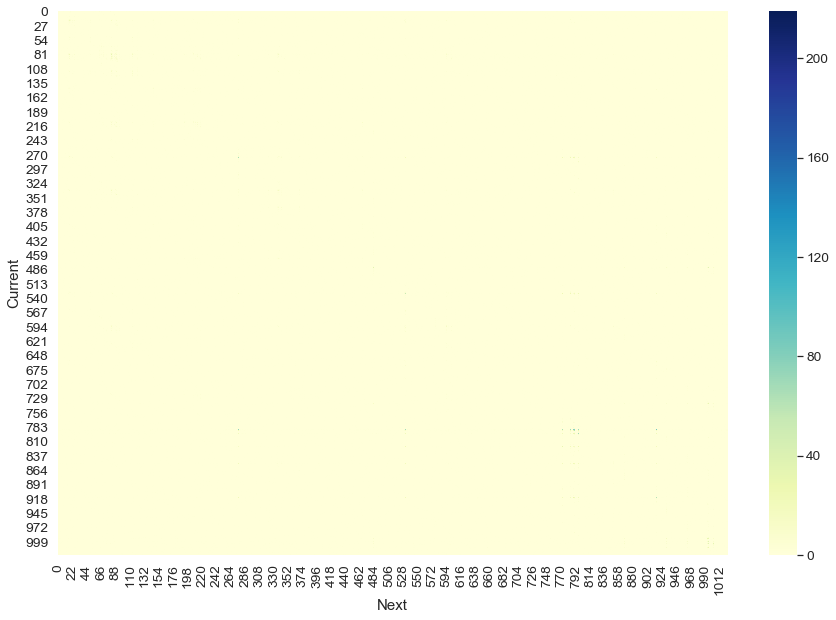

In [20]:
state_transitions = pd.crosstab(record_df['Current'], record_df['Next'])
sns.set(style='darkgrid', rc={'figure.figsize':(15,10)}, font_scale=1.25)
sns.heatmap(state_transitions, cmap="YlGnBu");